In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

Running on device: cuda


In [6]:
import sys
import os

# Append the parent directory (project root) to the sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [7]:
import h5py
import numpy as np
from torch.utils.data import DataLoader, Subset
from src.dataset import GalaxyDataset  # Assuming you have implemented a dataset class in src

file_path = '../data/raw/Galaxy10_DECals.h5'

# Load the whole dataset (or a preprocessed version if available)
with h5py.File(file_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert to tensors and set up dataset (if not already done in src)
images = torch.tensor(images, dtype=torch.float32) / 255.0   # normalize if needed
labels = torch.tensor(labels, dtype=torch.long)

# Create the dataset (this is similar to what you did in exploratory.ipynb)
dataset = GalaxyDataset(images, labels)

# For quick experiments, use a smaller subset
subset_indices = np.random.choice(len(dataset), size=1000, replace=False).tolist()
train_subset = Subset(dataset, subset_indices)
loader = DataLoader(train_subset, batch_size=32, shuffle=True)

print("Loaded subset size:", len(train_subset))

Loaded subset size: 1000


In [8]:
from src.models import SimpleCNN  # Ensure you've defined this in your src/models.py

# Instantiate the model and move it to GPU if available
model = SimpleCNN(num_classes=10).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [20]:
import torch.nn as nn
import torch.optim as optim

# Setup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Quick training loop over a small number of epochs/iterations
num_epochs = 2  # keep this low for a quick experiment
loss_values = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Ensure the input dimensions are appropriate (convert if needed)
        # For example: from (batch, height, width, channels) to (batch, channels, height, width)
        if inputs.shape[1] != 3:
            inputs = inputs.permute(0, 3, 1, 2)  # Now inputs become (batch, 3, height, width)
    
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if (i + 1) % 10 == 0:
            loss_values.append(running_loss/10)
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(loader)}], Loss: {running_loss/10:.4f}")
            running_loss = 0.0

Epoch [1/2], Step [10/32], Loss: 1.5306
Epoch [1/2], Step [20/32], Loss: 1.5566
Epoch [1/2], Step [30/32], Loss: 1.5047
Epoch [2/2], Step [10/32], Loss: 1.1833
Epoch [2/2], Step [20/32], Loss: 1.0906
Epoch [2/2], Step [30/32], Loss: 1.1421


In [21]:
# If you want to evaluate on the same loader for simplicity:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        if inputs.shape[1] != 3:
            inputs = inputs.permute(0, 3, 1, 2)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print("Accuracy on the subset: {:.2f}%".format(100 * correct / total))

Accuracy on the subset: 78.90%


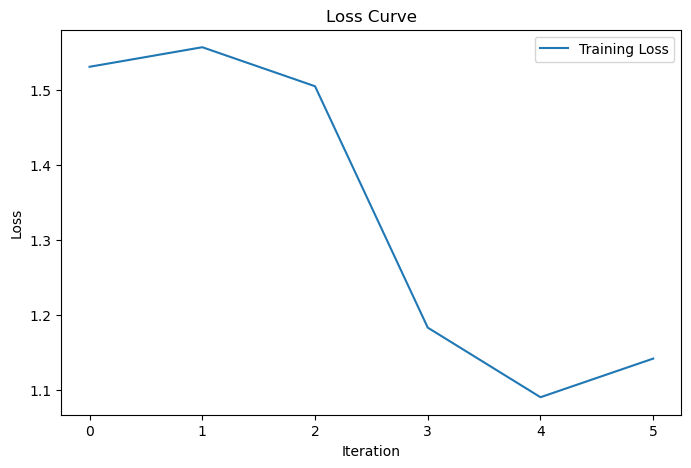

In [22]:
# Example: If you have stored loss values in a list called loss_values
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [5]:
# In experiments.ipynb
!python ../src/train.py --raw    # Run training on raw data

Using device: cuda
Starting Training!
Epoch [1/10] Train Loss: 1.9446, Train Acc: 0.3725 | Val Loss: 1.4514, Val Acc: 0.4940, Time: 10.185405 seconds
New best model saved at models/best_simple_cnn_raw.pth with Val Acc: 0.4940
Epoch [2/10] Train Loss: 1.0971, Train Acc: 0.6106 | Val Loss: 1.3254, Val Acc: 0.5586, Time: 9.069506 seconds
New best model saved at models/best_simple_cnn_raw.pth with Val Acc: 0.5586
Epoch [3/10] Train Loss: 0.6618, Train Acc: 0.7728 | Val Loss: 1.5625, Val Acc: 0.5432, Time: 9.464743 seconds
Epoch [4/10] Train Loss: 0.3478, Train Acc: 0.8893 | Val Loss: 1.8926, Val Acc: 0.5132, Time: 9.359734 seconds
Epoch [5/10] Train Loss: 0.1772, Train Acc: 0.9522 | Val Loss: 2.4803, Val Acc: 0.5229, Time: 9.673188 seconds
Epoch [6/10] Train Loss: 0.0977, Train Acc: 0.9791 | Val Loss: 2.6242, Val Acc: 0.5102, Time: 9.540138 seconds
Epoch [7/10] Train Loss: 0.0662, Train Acc: 0.9893 | Val Loss: 3.0197, Val Acc: 0.5154, Time: 9.330719 seconds
Epoch [8/10] Train Loss: 0.0522,

In [1]:
!python ../src/train.py     # Run training on augmented data for 20 epochs Powerful CNN

Using device: cuda
Starting Training!
Epoch [1/25] Train Loss: 2.0066, Train Acc: 0.2465 | Val Loss: 1.9223, Val Acc: 0.2628, Time: 18.228652 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.2628
Epoch [2/25] Train Loss: 1.8458, Train Acc: 0.3195 | Val Loss: 1.7875, Val Acc: 0.3492, Time: 17.734403 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.3492
Epoch [3/25] Train Loss: 1.7319, Train Acc: 0.3617 | Val Loss: 1.7711, Val Acc: 0.3632, Time: 17.766417 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.3632
Epoch [4/25] Train Loss: 1.6655, Train Acc: 0.3889 | Val Loss: 1.6371, Val Acc: 0.3962, Time: 17.748039 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.3962
Epoch [5/25] Train Loss: 1.6267, Train Acc: 0.4073 | Val Loss: 1.6164, Val Acc: 0.4038, Time: 17.789584 seconds
New best model saved at models/best_powerful_cnn_augmented.pth wit

In [7]:
!python ../src/train.py     # Run training on raw data for 25 epochs Powerful CNN

Using device: cuda
Starting Training!
Epoch [1/55] Train Loss: 1.9959, Train Acc: 0.2622 | Val Loss: 2.0274, Val Acc: 0.2188, Time: 18.354839 seconds
New best model saved at models/best_powerful_cnn_raw.pth with Val Acc: 0.2188
Epoch [2/55] Train Loss: 1.8838, Train Acc: 0.3014 | Val Loss: 1.8863, Val Acc: 0.3323, Time: 17.758336 seconds
New best model saved at models/best_powerful_cnn_raw.pth with Val Acc: 0.3323
Epoch [3/55] Train Loss: 1.7749, Train Acc: 0.3469 | Val Loss: 1.8544, Val Acc: 0.2966, Time: 17.826318 seconds
Epoch [4/55] Train Loss: 1.7013, Train Acc: 0.3790 | Val Loss: 1.9937, Val Acc: 0.3023, Time: 17.668549 seconds
Epoch [5/55] Train Loss: 1.6600, Train Acc: 0.3916 | Val Loss: 2.3292, Val Acc: 0.2282, Time: 17.791183 seconds
Epoch [6/55] Train Loss: 1.6236, Train Acc: 0.4031 | Val Loss: 1.6932, Val Acc: 0.3748, Time: 17.582651 seconds
New best model saved at models/best_powerful_cnn_raw.pth with Val Acc: 0.3748
Epoch [7/55] Train Loss: 1.6055, Train Acc: 0.4093 | Val

In [8]:
!python ../src/train_pc.py     # Run training on augmented data for 35 epochs Powerful CNN

Using device: cuda
Starting Training!
Epoch [1/55] Train Loss: 1.9933, Train Acc: 0.2451 | Val Loss: 1.9438, Val Acc: 0.2797, Time: 18.624636 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.2797
Epoch [2/55] Train Loss: 1.8735, Train Acc: 0.2947 | Val Loss: 1.9502, Val Acc: 0.2613, Time: 17.992102 seconds
Epoch [3/55] Train Loss: 1.8364, Train Acc: 0.3046 | Val Loss: 1.8652, Val Acc: 0.2944, Time: 17.997212 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.2944
Epoch [4/55] Train Loss: 1.8097, Train Acc: 0.3232 | Val Loss: 1.7958, Val Acc: 0.3417, Time: 17.942172 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.3417
Epoch [5/55] Train Loss: 1.7466, Train Acc: 0.3592 | Val Loss: 1.7570, Val Acc: 0.3432, Time: 17.850637 seconds
New best model saved at models/best_powerful_cnn_augmented.pth with Val Acc: 0.3432
Epoch [6/55] Train Loss: 1.6981, Train Acc: 0.3749 | Val Loss: 1.7

In [5]:
!python ../src/train_scr.py     # Run training on raw data for 35 epochs simple CNN

Using device: cuda
Starting Training!
Epoch [1/35] Train Loss: 2.3536, Train Acc: 0.3049 | Val Loss: 1.6024, Val Acc: 0.4150, Time: 7.967140 seconds
New best model saved at models/best_simple_cnn_raw.pth with Val Acc: 0.4150
Epoch [2/35] Train Loss: 1.2789, Train Acc: 0.5404 | Val Loss: 1.3425, Val Acc: 0.5380, Time: 7.136602 seconds
New best model saved at models/best_simple_cnn_raw.pth with Val Acc: 0.5380
Epoch [3/35] Train Loss: 0.7960, Train Acc: 0.7274 | Val Loss: 1.4281, Val Acc: 0.5560, Time: 7.836825 seconds
New best model saved at models/best_simple_cnn_raw.pth with Val Acc: 0.5560
Epoch [4/35] Train Loss: 0.3880, Train Acc: 0.8785 | Val Loss: 1.8078, Val Acc: 0.5425, Time: 8.082353 seconds
Epoch [5/35] Train Loss: 0.1866, Train Acc: 0.9519 | Val Loss: 2.2333, Val Acc: 0.5124, Time: 7.450686 seconds
Epoch [6/35] Train Loss: 0.0995, Train Acc: 0.9808 | Val Loss: 2.5922, Val Acc: 0.5173, Time: 7.520984 seconds
Epoch [7/35] Train Loss: 0.0710, Train Acc: 0.9885 | Val Loss: 2.771

In [9]:
!python ../src/train_sca.py     # Run training on augmented data for 35 epochs simple CNN

Using device: cuda
Starting Training!
Epoch [1/55] Train Loss: 2.1395, Train Acc: 0.2814 | Val Loss: 1.7033, Val Acc: 0.3628, Time: 9.961777 seconds
New best model saved at models/best_simple_cnn_augmented.pth with Val Acc: 0.3628
Epoch [2/55] Train Loss: 1.5518, Train Acc: 0.4222 | Val Loss: 1.4615, Val Acc: 0.4647, Time: 10.305109 seconds
New best model saved at models/best_simple_cnn_augmented.pth with Val Acc: 0.4647
Epoch [3/55] Train Loss: 1.3837, Train Acc: 0.4897 | Val Loss: 1.3667, Val Acc: 0.4989, Time: 10.662315 seconds
New best model saved at models/best_simple_cnn_augmented.pth with Val Acc: 0.4989
Epoch [4/55] Train Loss: 1.3073, Train Acc: 0.5300 | Val Loss: 1.2988, Val Acc: 0.5335, Time: 10.156759 seconds
New best model saved at models/best_simple_cnn_augmented.pth with Val Acc: 0.5335
Epoch [5/55] Train Loss: 1.2548, Train Acc: 0.5431 | Val Loss: 1.3074, Val Acc: 0.5391, Time: 10.346541 seconds
New best model saved at models/best_simple_cnn_augmented.pth with Val Acc: 

In [3]:
!python ../src/train_pc.py     # Run training on augmented data for 35 epochs simple CNN

Using device: cpu
/home/bhora.y/.conda/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Starting Training!
^C


In [2]:
!python transfer_learning.py

Using device: mps
model.safetensors: 100%|███████████████████| 36.8M/36.8M [00:00<00:00, 61.7MB/s]
Epoch [1/10] Train Loss: 1.0485, Train Acc: 0.6594 | Val Loss: 0.7764, Val Acc: 0.7406
New best model saved at models/best_efficientnet_raw.pth with Val Acc: 0.7406
Epoch [2/10] Train Loss: 0.6016, Train Acc: 0.8009 | Val Loss: 0.7340, Val Acc: 0.7714
New best model saved at models/best_efficientnet_raw.pth with Val Acc: 0.7714
Epoch [3/10] Train Loss: 0.4663, Train Acc: 0.8429 | Val Loss: 0.6335, Val Acc: 0.7921
New best model saved at models/best_efficientnet_raw.pth with Val Acc: 0.7921
Epoch [4/10] Train Loss: 0.3925, Train Acc: 0.8695 | Val Loss: 0.6163, Val Acc: 0.7970
New best model saved at models/best_efficientnet_raw.pth with Val Acc: 0.7970
Epoch [5/10] Train Loss: 0.3022, Train Acc: 0.8972 | Val Loss: 0.7080, Val Acc: 0.7880
Epoch [6/10] Train Loss: 0.2542, Train Acc: 0.9177 | Val Loss: 0.7716, Val Acc: 0.7921
Epoch [7/10] Train Loss: 0.2069, Train Acc: 0.9327 | Val Loss: 0.74

In [4]:
!python transfer_learning.py # Augmented data

Using device: mps
Starting Training!
^C
Traceback (most recent call last):
  File "/Users/yashbhora/Library/CloudStorage/OneDrive-NortheasternUniversity/Classes/DS 4420 Machine Learning & Data Mining 2/ds4420_final/galaxy_classification/transfer_learning.py", line 166, in <module>
    main(raw=False, model_type='efficientnet')
  File "/Users/yashbhora/Library/CloudStorage/OneDrive-NortheasternUniversity/Classes/DS 4420 Machine Learning & Data Mining 2/ds4420_final/galaxy_classification/transfer_learning.py", line 109, in main
    for inputs, targets in train_loader:
  File "/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1318, in _next_data
    self._shutdown_workers()
  File "/opt/anaconda3/envs/mldl/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 144